## Download the model and metadata if necessary

In [2]:
import os

!pip install yacs opencv-python json_tricks pycocotools

if not os.path.isfile('pose_hrnet_w48_384x288.pth'):
    !curl -O https://eurmqg.ch.files.1drv.com/y4mNy2IRQtZ8_2fiDe8-Usmo4MGjRnWRgb2y3jGIx8wq5PQ4ABVUqSZqaumGtuUfhjQpNN8OlpOQZB3Q5gZ11lif97gLj8zaKgPgyYzFdgd8yIiq8rFWsh5oTIxCh9UTyah8gxiqS9ldmIp24C_zKrNOXrMwttYDiMZdA8XaY-g5t3bt2G37fjfWk6qnkyb7lHUFaW-zUhddzpClyRgYCNZYA/pose_hrnet_w48_384x288.pth

if not os.path.isdir('deep-high-resolution-net.pytorch'):
    !git clone https://github.com/leoxiaobin/deep-high-resolution-net.pytorch.git
    !cd deep-high-resolution-net.pytorch/lib/nms/ && python setup_linux.py build && python setup_linux.py install

## Load the libraries and the model

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0, 'deep-high-resolution-net.pytorch/lib')
sys.path.insert(1, 'deep-high-resolution-net.pytorch/lib/nms/')
sys.path.insert(2, 'deep-high-resolution-net.pytorch/lib/models/')

import cv2
import torch
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms

from config import cfg
from config import update_config
#from core.loss import JointsMSELoss
#from core.function import validate
from core.inference import get_max_preds

import pose_hrnet
import dataset

In [2]:
class ARGS(object):
    pass
args = ARGS()
args.cfg = 'deep-high-resolution-net.pytorch/experiments/coco/hrnet/w48_384x288_adam_lr1e-3.yaml'
args.opts = ''
args.modelDir = '.'
args.logDir = '.'
args.dataDir = '.'
args.TEST = ARGS()
args.TEST.BATCH_SIZE_PER_GPU = 1
args.WORKERS = 1
args.GPUS = (0)
args.TEST.MODEL_FILE = 'pose_hrnet_w48_384x288.pth'
args.TEST.USE_GT_BBOX = True
update_config(cfg, args)

In [3]:
model = pose_hrnet.get_pose_net(cfg, is_train=False)
model.load_state_dict(torch.load('pose_hrnet_w48_384x288.pth'))

## Prepare a transformer for normalizing the input

In [4]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
transformer = transforms.Compose([
    transforms.ToTensor(),
    normalize,
])

In [5]:
def predict(img):
    # let's normalize the image and transform it into a pytorch tensor
    batch = transformer(cv2.resize(img, (384, 288)))
    out = model(batch.unsqueeze(0))
    
    # Ok. Now we need to extract the keypoints from each heatmap¶
    coords, maxvals = get_max_preds(out.clone().cpu().detach().numpy())
    img_h, img_w, _ = img.shape
    mask_h, mask_w = out.shape[2:4]
    return np.append((coords[0] / (mask_w, mask_h) * (img_w, img_h)), maxvals[0], axis=1)

## Let's do a basic test
### First, let's load an image

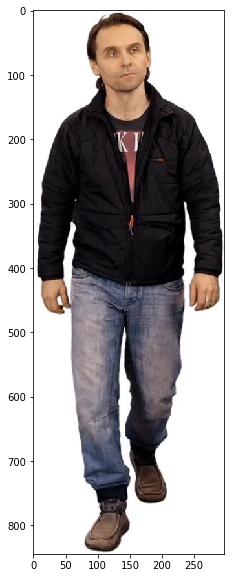

In [6]:
img = cv2.imread('man_walking.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(img)

### Now, let's do the prediction
The output in this case is a matrix with the heatmaps for all the 17 keypoints. Each heatmap is a mask with the resolution of W=96 and H=72

In [7]:
%%time

keypoints = predict(img)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


CPU times: user 6.86 s, sys: 1.62 s, total: 8.48 s
Wall time: 2.15 s


### Now, let's plot an image with the predicted keypoints

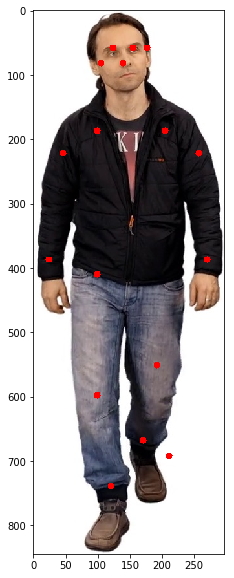

In [8]:
img3 = img.copy()
for k in keypoints:
    cv2.circle(img3, (int(k[0]), int(k[1])), 5, (255,0,0), -1)
plt.figure(figsize=(10,10))
plt.imshow(img3)

    {0,  "Nose"},
    {1,  "LEye"},
    {2,  "REye"},
    {3,  "LEar"},
    {4,  "REar"},
    {5,  "LShoulder"},
    {6,  "RShoulder"},
    {7,  "LElbow"},
    {8,  "RElbow"},
    {9,  "LWrist"},
    {10, "RWrist"},
    {11, "LHip"},
    {12, "RHip"},
    {13, "LKnee"},
    {14, "Rknee"},
    {15, "LAnkle"},
    {16, "RAnkle"},

Done :)